In [519]:
import chess.pgn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lichess.api
from chess import Move
from lichess.format import PGN
import json
import warnings
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

**Project Topic**

This project aims to build a chess outcomes classifier using the supervised learning method of K-Nearest Neighbors. My aim in exploring this project is delve into exploring classification of more complicated datasets and also to gain insight on renown classifiers and chess engines like Stockfish.

**Data Description** 
<br>
<br>
May 2015 online chess game data from the lichess games database (https://database.lichess.org/)

Contains various features such as game format, player usernames and elo, means of winning (timeout/normal ending), the result of the game, and the series of moves played by both players as well as a few other relatively insignficant features like date and time. All the used features are typed as various chess objects that are mostly similar to strings except for elo which is an int.
<br>
<br>
<br>
**Data Processing and Cleaning**
<br>
<br>
Reads through the PGN stream of games using the Python Chess library and builds an array of games initially dropping games which are missing the moves object since it is by far the most important feature for this project, also later dropped rows where the moves was NaN. Removed features which were intuitively unimportant for this project such as usernames, date & time (all the games are from the same month and year), the replay link, etc. 

The only issues that arose were in processing as many games as I would have liked, the data subset I chose has roughly 2 million games but I faced difficulty processing more than a couple hundred thousand games. Roughly 0.96% of games were removed because of missing or NaN values in the moves feature, all other features were properly cleaned before. More information on result of data cleaning can be found below. 


In [237]:
pgn = open("lichess_db_standard_rated_2015-05.pgn") # Open PGN file with games data
n = 200000 # number of games to process
games = [0] * n # array which stores rows representing each game
for x in range(n):
    game = chess.pgn.read_game(pgn) # read next stream object
    try: # if the game has a moves section
        moves = list(game.mainline_moves())
    except: # if there is no moves section ignore this game
        continue
    # Collect various other potential features: format, elo, winner, loss on time/checkmate, and time control
    row = [game.headers[e] for e in ['Event','WhiteElo','BlackElo','Result','Termination','TimeControl']]
    row.append(moves) # add moves to end of row
    games[x] = row # add row to array
print("DONE")

DONE


In [317]:
# Remove rows with type errors because there was no move set
games = [x for x in games if isinstance(x, list)]
# reformat data so it can exported to csv
try:
    for game in games:
        game[-1] = ' '.join([move.uci() for move in game[-1]])
except:
    print("Already converted")

Already converted


In [318]:
# Read array into dataframe, then export it to a csv for easier use later 
# commented so I don't accidentally overwrite the file
df = pd.DataFrame(games, columns = ['Event','WhiteElo','BlackElo','Result','Termination','TimeControl','Moves'])
df.to_csv('out2.csv', encoding='utf-8', index=False)

In [360]:
# IMPORT dataframe from file so don't have to process games again and drop games without moves
df = pd.read_csv('out2.csv')
missing = n-len(df) # number of rows with missing moves
df = df.dropna(subset=['Moves']) # remove rows which have no moves
nanval = n-missing-len(df) # number of rows with NaN value in moves column
df = df.reset_index(drop=True) # fix indices after dropping rows
#fix moves formatting after importing
for i, row in df.iterrows():
    moves_uci = row['Moves'].split()  
    moves = [chess.Move.from_uci(move_uci) for move_uci in moves_uci]  
    df.at[i, 'Moves'] = moves

counts = df['Termination'].value_counts() # counts of each unique value in termination column
normalend = counts['Normal'] # number of normal ending games
timeff = counts['Time forfeit'] # number of games won by timeout
cheating = counts['Rules infraction'] # number of games ended because of cheating
df = df[df['Termination'] != 'Rules infraction'] # drop games ended by cheating
df['AverageElo'] = (df['WhiteElo']+df['BlackElo']) / 2 # add a column for the average elo of the game


**Data Cleaning Results and EDA**
<br>
<br>
Below are the results from cleaning the data and a start to exploring the data, particularly the classification of the games.

Total Games Processed:  200000
Games removed due to missing or NaN move sets:  1908
Games removed due to cheating:  8
Games remaining:  198084
Proportion of games removed:  0.00962
Games lost to timing out:  62318
Games with normal endings (Checkmate/Stalemate/Other Draws):  134913


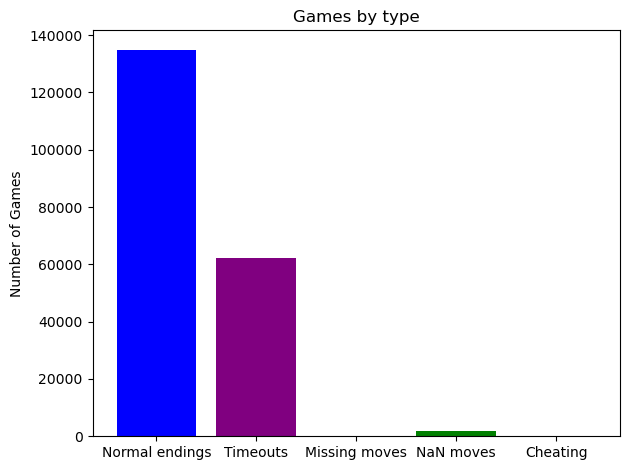

In [362]:
print("Total Games Processed: ", n)
print("Games removed due to missing or NaN move sets: ", n-len(df)-cheating)
print("Games removed due to cheating: ", cheating)
print("Games remaining: ", len(df))
print("Proportion of games removed: ", (n-len(df)+cheating)/n)
print("Games lost to timing out: ", timeff)
print("Games with normal endings (Checkmate/Stalemate/Other Draws): ", normalend)

labels = ['Normal endings','Timeouts','Missing moves', 'NaN moves', 'Cheating']
fig, ax = plt.subplots()
ax.bar(0, normalend, color='blue')
ax.bar(1, timeff, color='purple')
ax.bar(2, missing, color='orange')
ax.bar(3, nanval, color='green')
ax.bar(4, cheating, color='red')

ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(labels)
ax.set_ylabel('Number of Games')
ax.set_title('Games by type')

plt.tight_layout()
plt.show()

**EDA Continued**
<br>
<br>
I'm planning to primarily focus on using the moves feature to attempt to predict the outcomes of the games. To do so, I will have to transform the moves data set in two ways, first by slicing either a proportion of the set or a specific number of moves off the end so as to make the outcome unknown. Then I will have to convert the moves to a metric the models can use. For this, I am planning to use Jaccard distance to compare how similar two different games were.

I explored the distribution of games by elo and the frequencies of timeouts by Elo below. Surprisingly, I observed the trend of timeout frequency increasing (with the exception of the last bracket though sample size is extremely small there) increasing with elo instead of the opposite. I may try to monitor performance across different categories such as elo or format or ignoring games which were timeouts or too short.

I also began my feature engineering for the moves set to convert them into a distance metric for my K-Nearest Neighbors classifier and the exploratory results for that can also be found below. One problem I am expecting to encounter is having to reduce the number of samples I am using or testing since it would be far too computationally taxing to compute 200,000^2 distances and I'm unsure of how to implement a significantly better solution. I found that the games on average had a fairly high distance to other games but there were consistently neighbors which were much closer, hopefully this indicates that my model will correctly identify games which proceeded similarly and have good results.

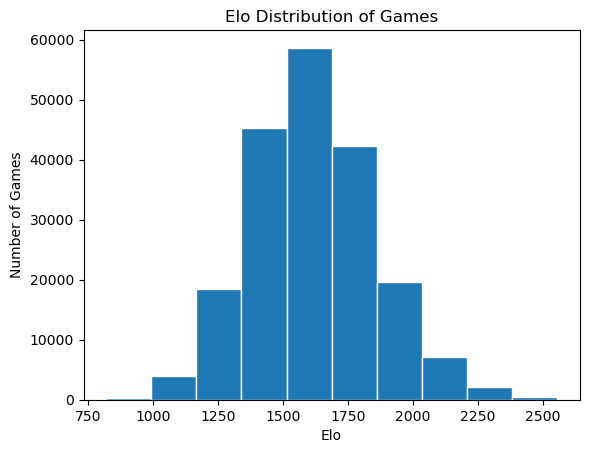

In [363]:
_, bin_edges, _ = plt.hist(df['AverageElo'], bins=10, edgecolor='white') # plot elo by frequency
plt.xlabel('Elo')
plt.ylabel('Number of Games')
plt.title('Elo Distribution of Games')
plt.show()

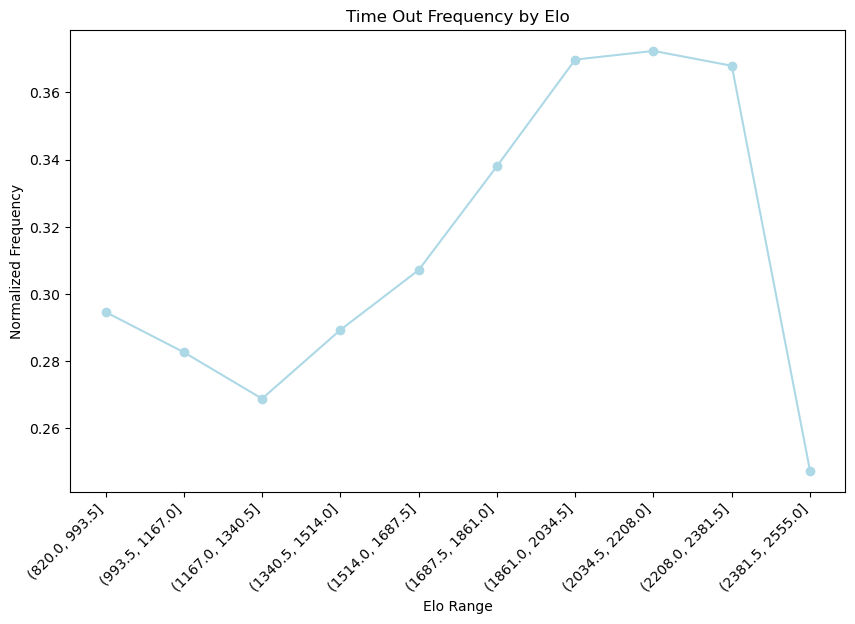

In [364]:
# get counts of normal endings and timeouts by elo bracket
term_freq = df.groupby(pd.cut(df['AverageElo'], bins=bin_edges))['Termination'].value_counts() 
term_freq /= term_freq.groupby(level=0).transform('sum') # normalize counts to frequencies
term_freq = term_freq.reset_index(name='Frequency') # rename that column frequency
term_freq = term_freq[term_freq['Termination'] == 'Time forfeit'] # only want to show frequency of timeouts
# plotting stuff
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(10, 6))
binlabels = [str(interval) for interval in term_freq['AverageElo'].unique()]
ax.plot(binlabels, term_freq['Frequency'], marker='o', color='lightblue')
ax.set_xticklabels(binlabels,rotation=45, ha="right")
plt.xlabel('Elo Range')
plt.ylabel('Normalized Frequency')
plt.title('Time Out Frequency by Elo')

plt.show()

**Feature Engineering**
<br>
<br>
Here, I slice my moves and convert them into a distance metric which can be understood by my model and convert the results into a numeric label for the classifier.

In [466]:
def jaccard_distance(moves1, moves2):
    # reformat moves as needed
    moves1_uci = {move.uci() if isinstance(move, chess.Move) else move for move in moves1}
    moves2_uci = {move.uci() if isinstance(move, chess.Move) else move for move in moves2}
     # Calculate the Jaccard similarity
    intersection = moves1_uci.intersection(moves2_uci)
    union = moves1_uci.union(moves2_uci)
    # Return Jaccard distance
    return 1 - len(intersection) / len(union)

# add 2 columns for slices of the movesets
df['1/2Moves'] = df['Moves'].apply(lambda x: x[:len(x)//2]) # column with first half of moves
df['3/4Moves'] = df['Moves'].apply(lambda x: x[:3*len(x)//4]) # column with first 3/4ths of moves
result_mapping = {
    '1-0': 0,      # White wins
    '0-1': 1,      # Black wins
    '1/2-1/2': 2    # Draw
}
df['ResultLabels'] = df['Result'].map(result_mapping)
df = df.reset_index(drop=True) # fix indices 

dfShort = df.iloc[:10000].copy() # df with only 10,000 rows to ease computing time

dds = []
ds = []
for j in range(10):
    for i in range(len(dfShort)):
        if i == j: # ignore diagonals
            continue
        d = jaccard_distance(list(dfShort['1/2Moves'][j]),list(dfShort['1/2Moves'][i]))
        ds.append(d)
    dds.append(ds)

Average distance between games:  0.8653794394925541
Minimum distance between games:  0.25
Maximum distance between games:  1.0


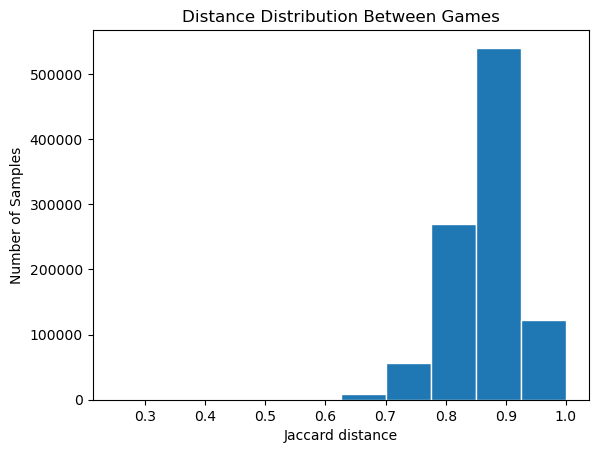

In [467]:
print("Average distance between games: ",np.mean(dds))
print("Minimum distance between games: ",np.min(dds))
print("Maximum distance between games: ",np.max(dds))
ds_flat = [item for sublist in dds for item in sublist] # flatten distances array 
plt.hist(ds_flat, bins=10, edgecolor='white') # plot elo by frequency
plt.xlabel('Jaccard distance')
plt.ylabel('Number of Samples')
plt.title('Distance Distribution Between Games')
plt.show()

In [507]:
# Builds a KNN classifier
class KNN: 
    def __init__(self, x_train, y_train, K=5):
        self.x_train = x_train
        self.y_train = y_train
        self.K = K 
     
    # identifies majority label
    def majority(self, neighbor_indices, neighbor_distances=None): 
        neighbors = list(neighbor_indices) # indexes of nearest neighbors
        k = self.K
        while k > 1:
            knn_labels = [self.y_train.iloc[x] for x in neighbors[:k]] # labels of k nearnest neighbors
            labels = {}
            for x in knn_labels: # label counts
                if labels.get(x):
                    labels[x] += 1
                else:
                    labels[x] = 1
            
            # majority label checks
            max_label = max(labels, key=labels.get) 
            max_count = list(labels.values()).count(labels[max_label])
            
            if max_count == 1:
                return max_label
            k-=1
        return self.y_train.iloc[neighbors[0]] # default return label of nearest neighbor
        
    # builds a sorted list of nearest neighbors by jaccard distance and passes it to majority, returns classification
    def classify(self, x): 
        distances_with_indices = [(jaccard_distance(x, z), idx) for idx, z in enumerate(self.x_train) if x != z]
        sorted_distances_with_indices = sorted(distances_with_indices, key=lambda pair: pair[0])
        indices = [idx for _, idx in sorted_distances_with_indices]
        res = self.majority(indices)
        return res
        
    # classifies the labels of all points in X and returns the predicted labels
    def predict(self, X):
        res = []
        for m in X:
            res.append(self.classify(m))
        return res

# calculates the accuracy of the predictions
def calculate_accuracy(y_true, y_pred):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct+=1
    return correct/len(y_true)

**Hyperparamter Tuning and Results**
<br>
<br>
Here I try to optimize the number of neighbors that I'm using in my KNN classifier.

In [508]:
df = df.reset_index(drop=True) # fix indices 
dfShort = dfShort.reset_index(drop=True) # fix indices
X = dfShort['1/2Moves']
y = dfShort['ResultLabels']
accs = []
for k in range(1,5):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=200)
    knn = KNN(x_train, y_train, K=k)
    val_yhat = knn.predict(x_test) 
    accs.append(calculate_accuracy(list(y_test), val_yhat))

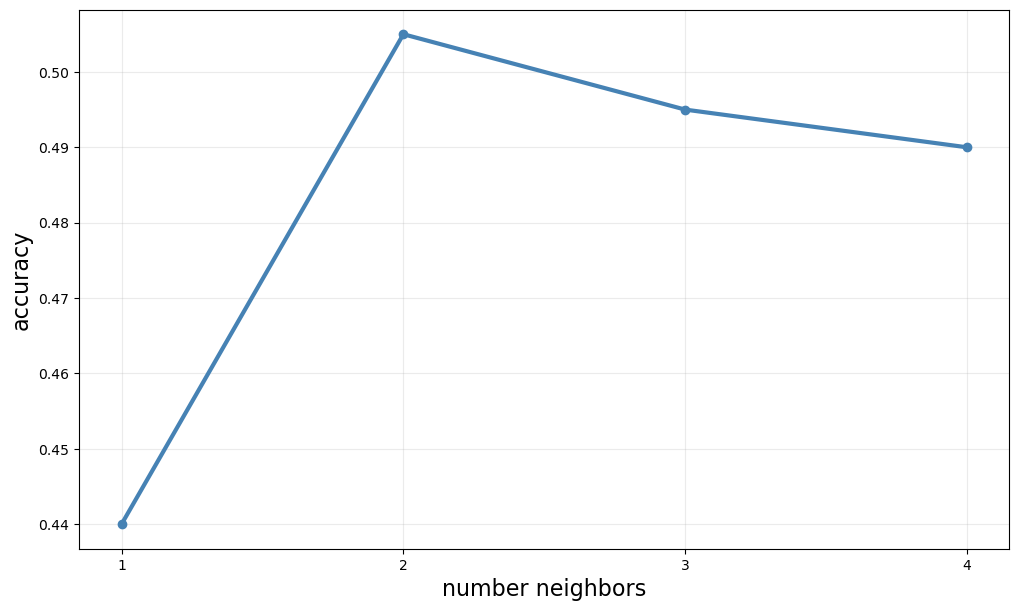

In [510]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(range(1,5), accs, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1,5))
ax.grid(alpha=0.25)

In [521]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=500)
knn = KNN(x_train, y_train, K=2)
val_yhat = knn.predict(x_test)

print("K = 2 accuracy for larger test size: ",calculate_accuracy(list(y_test), val_yhat))

K = 2 accuracy for larger test size:  0.498


In [524]:
print("Class Label Frequencies: ")
print(dfShort['ResultLabels'].value_counts()/len(dfShort))

precision = precision_score(list(y_test), val_yhat, average=None) 
print(f"Precision by Class: {precision}")

recall = recall_score(list(y_test), val_yhat, average=None) 
print(f"Recall by Class: {recall}")

Class Label Frequencies: 
0    0.5020
1    0.4664
2    0.0316
Name: ResultLabels, dtype: float64
Precision by Class: [0.52651515 0.472103   0.        ]
Recall by Class: [0.54940711 0.47826087 0.        ]


**Analysis**
<br>
<br>
First, I used hyperparameter tuning to optimize my choice for k in order to improve my model. I started to observe significant computational limitations, so limited the number of k's explored. I observed a similar trend to previous KNN use cases, so the observation of k = 2 producing the best value is likely correct.

My model performed at an accuracy of around 50%. Though 50% is not a good result, compared to the performance of a true random predictor for 3 labels, which would guess all labels equally resulting in 33.3% accuracy my model performs significantly better. At the least, this indicates my model is learning a significant amount of information from the data. This is supported by the significant variance in accuracy with number of neighbors which also indicates that the model is doing more than simply predicting the most frequent class label.

I used multiple metrics with per-class precision and recall and found that for the not-stalemate classes my model did slightly outperform prediction by label frequency. For the stalemate class my model did not correctly predict games as such a single time, likely due to the low frequency and absolute number of stalemate games in my sample.

**Discussion and Conclusion**
<br>
<br>
There was a lot to be learned from this project. Foremost, I think I vastly underestimated the difficulty of processing so much data using the metrics and models I selected, which is apparent from trimming my data subset down to 0.5% of what I originally intended. I think taking more steps to evaluate the complexity of my individual features, in this case my moves and how nuanced they were would have made an immeasurable difference in proceeding analysis and model selection.

I think one of the obvious reasons my model didn't see great success was because the model was a poor fit given my computational limitations on processing the data. The KNN model likely performed poorly for two reasons. Firstly, the amount of neighbors to sample (10,000) was far too few for a game like chess which has a valid state space between 10^40 and 10^50 positions. There are just far too many variations in the game to be able to find very good neighbors with such few options. Secondly, using a metric as simple as Jaccard distance was likely a poor choice. Given the nature of chess, once one move differs from another game it's likely that most or all of the following moves will also differ. This is bad because while it likely identifies games which start off similarly as close neighbors it fails to keep track of them because there are often many moves at any point which serve a similar purpose.

As for ways to improve though changing the distance metric and being able to use a greater number of samples as mentioned above would help, I think using a different model would likely make a much larger difference. A model which was better at capturing the complexities of chess moves such as gradient boosting, random forests, or even decision trees with proper feature engineering to support them would likely show much better performance while being much less computationally expensive. 